# **Food Commodity Prices Analysis and Forecasting in Kenya**

**By:** Charles Kagwanja   **|**   Kevin Kagia  |   Lucy Njambi  | 
 Mwenda Mugambi


---


## **Introduction**
The focus of this project is to analyze and predict the dynamics of food commodity prices in various regions of Kenya. This initiative is essential in a country where agriculture is not only a key economic driver but also vital to the sustenance of its population. The fluctuation in food prices significantly impacts consumers, retailers, farmers, and policymakers. Understanding these price trends and being able to forecast future changes are crucial for effective agricultural planning, budgeting, and policy-making.

### Why This Project Matters

1. **Economic Impact on Farmers and Producers**: Empowering farmers with the knowledge of future price trends, which can guide their crop production and marketing strategies.

2. **Consumer Protection and Budgeting**: Assisting consumers, especially in lower-income groups, to better plan their food budgets.

3. **Policy Making and Food Security**: Enabling policymakers to formulate strategies that can stabilize food markets and ensure food security.

4. **Retail and Distribution Management**: Helping retailers and distributors in optimizing their inventory and pricing strategies.

5. **Aid and Intervention Planning**: Assisting NGOs and international organizations in planning and distributing aid more effectively.

6. **Market Stability and Investment**: Attracting investment in the agricultural sector by providing a clearer understanding of market dynamics.

7. **Research and Development**: Contributing to academic and practical research in market dynamics and agricultural economics.

### Goals of the Project

- **Analyzing Price Trends and Seasonality**: Identify historical patterns in commodity prices across different markets in Kenya.
- **Understanding Regional Variations**: Examine price differences across various regions to understand market dynamics.
- **Forecasting Future Prices**: Develop models to predict future commodity prices.


### Primary Stakeholders

- Kenyan Ministry of Agriculture
- Farmers' Associations and Agricultural Cooperatives
- Retailers and Market Analysts
- Non-Governmental Organizations and International Bodies
- The General Public

## **Business Understanding**

This project aims to provide actionable insights into the trends and future predictions of food commodity prices in Kenya. By leveraging data science and time series forecasting methods, this project seeks to contribute towards more stable and predictable food markets in Kenya.

## **Data Understanding**
### Data Source

The dataset for this project was obtained from the Humanitarian Data Exchange (HDX), specifically from the World Food Programme's food price database for Kenya. The dataset can be accessed [here](https://data.humdata.org/dataset/wfp-food-prices-for-kenya).

This dataset is particularly suitable for our analysis due to the following reasons:
1. **Comprehensiveness**: It covers a wide range of food commodities and spans multiple regions within Kenya.
2. **Relevance**: The data directly relates to the prices of food commodities, which is the central focus of our project.
3. **Timeliness**: The dataset includes recent data, which is crucial for accurate forecasting.

First, we'll load the dataset and take a preliminary look at its structure, types of data it contains, and any initial observations we can make about it.

In [1]:
# Importing necessary Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Dataset Overview
Here, we will load the dataset and present its size, and an overview of its features.

In [2]:
# Loading the dataset
data = pd.read_csv("Data/wfp_food_prices_ken.csv")

# Checking the size of the dataset
print(f"\nThe dataset contains {data.shape[0]} rows and {data.shape[1]} columns.\n")


The dataset contains 15736 rows and 14 columns.



In [3]:
# Checking the columns in our dataframe
data.columns

Index(['date', 'admin1', 'admin2', 'market', 'latitude', 'longitude',
       'category', 'commodity', 'unit', 'priceflag', 'pricetype', 'currency',
       'price', 'usdprice'],
      dtype='object')

#### **Column Descriptions**
- <code><b>(date):</b></code>, Indicates the date of the price recording
- <code><b>Administrative Levels (admin1, admin2):</b></code>, Geographical categorizations, Representing different regions and sub-regions in Kenya.
- <code><b>(market):</b></code>,  The specific market where prices were recorded.
- <code><b>(latitude, longitude): </b></code>,  The geographical location of each market.
- <code><b> (category): </b></code>, The type of food commodity (e.g., cereals, pulses).
- <code><b> (commodity): </b></code>, The specific food item (e.g., Maize, Beans).
- <code><b> (unit): </b></code>,The unit of measurement for the price.
- <code><b> (priceflag): </b></code>, Indicates the nature of the price data (e.g., actual, estimated).
- <code><b> (pricetype): </b></code>, Whether the price is retail or wholesale.
- <code><b> (currency):</b></code>, The currency in which the price is given.
- <code><b> (price): </b></code>, The price of the commodity in Kenyan Shillings.
- <code><b> (usdprice): </b></code>,  The price converted to US Dollars.

In [4]:
# Displaying general information about the dataset 
# to confirm if the datatypes in the description match the expected entries in our dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15736 entries, 0 to 15735
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       15736 non-null  object
 1   admin1     15736 non-null  object
 2   admin2     15736 non-null  object
 3   market     15736 non-null  object
 4   latitude   15736 non-null  object
 5   longitude  15736 non-null  object
 6   category   15736 non-null  object
 7   commodity  15736 non-null  object
 8   unit       15736 non-null  object
 9   priceflag  15736 non-null  object
 10  pricetype  15736 non-null  object
 11  currency   15736 non-null  object
 12  price      15736 non-null  object
 13  usdprice   15736 non-null  object
dtypes: object(14)
memory usage: 1.7+ MB


In [5]:
# Displaying data entries to get a glimpse of our dataset.
data

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+flag,#item+price+type,#currency,#value,#value+usd
1,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,cereals and tubers,Maize (white),90 KG,actual,Wholesale,KES,1480.0,20.5041
2,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,pulses and nuts,Beans,KG,actual,Wholesale,KES,33.63,0.4659
3,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,pulses and nuts,Beans (dry),90 KG,actual,Wholesale,KES,3246.0,44.9705
4,2006-01-15,Eastern,Kitui,Kitui,-1.366667,38.016667,cereals and tubers,Maize (white),KG,actual,Retail,KES,17.0,0.2355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15731,2023-08-15,North Eastern,Garissa,Dagahaley (Daadab),0.185656,40.291621,miscellaneous food,Salt,200 G,aggregate,Retail,KES,10.0,0.07
15732,2023-08-15,North Eastern,Garissa,Dagahaley (Daadab),0.185656,40.291621,miscellaneous food,Sugar,KG,aggregate,Retail,KES,138.46,0.9696
15733,2023-08-15,North Eastern,Garissa,Dagahaley (Daadab),0.185656,40.291621,oil and fats,Oil (vegetable),L,aggregate,Retail,KES,259.23,1.8153
15734,2023-08-15,North Eastern,Garissa,Dagahaley (Daadab),0.185656,40.291621,pulses and nuts,Beans (dry),KG,aggregate,Retail,KES,191.67,1.3422


### Initial cleaning of the dataset

From these outputs, we can see that the first row seems to contain unnecessary headers. We can go ahead and drop that row.
We will also go ahead to convert the **date, latitude, longitude, price,** and **usdprice** columns to their appropriate data types.

In [6]:
# Removing the first row
data = data.drop(index=0)
print(f"\nThe dataset now contains {data.shape[0]} rows and {data.shape[1]} columns after dropping the first row.\n")

# Converting appropriate columns to their correct data types
data['date'] = pd.to_datetime(data['date'])
data['latitude'] = pd.to_numeric(data['latitude'], errors='coerce')
data['longitude'] = pd.to_numeric(data['longitude'], errors='coerce')
data['price'] = pd.to_numeric(data['price'], errors='coerce')
data['usdprice'] = pd.to_numeric(data['usdprice'], errors='coerce')



The dataset now contains 15735 rows and 14 columns after dropping the first row.



In [9]:
#Confirming the change to the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15735 entries, 1 to 15735
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       15735 non-null  datetime64[ns]
 1   admin1     15735 non-null  object        
 2   admin2     15735 non-null  object        
 3   market     15735 non-null  object        
 4   latitude   15735 non-null  float64       
 5   longitude  15735 non-null  float64       
 6   category   15735 non-null  object        
 7   commodity  15735 non-null  object        
 8   unit       15735 non-null  object        
 9   priceflag  15735 non-null  object        
 10  pricetype  15735 non-null  object        
 11  currency   15735 non-null  object        
 12  price      15735 non-null  float64       
 13  usdprice   15735 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(9)
memory usage: 1.8+ MB


Great. now we can see that the datatypes have been updated to the appropriate types and we can also see that we don't have any missing values.

###  Basic Statistics
In this section, We'll get a brief statistical overview of the numerical features in the dataset.

In [21]:
# Displaying basic statistics
data.describe(include='all', datetime_is_numeric=True)

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
count,15735,15735,15735,15735,15735.000000,15735.000000,15735,15735,15735,15735,15735,15735,15735.000000,15735.000000
unique,NaN,7,22,62,NaN,NaN,8,47,14,2,2,1,NaN,NaN
top,NaN,Rift Valley,Nairobi,Nairobi,NaN,NaN,cereals and tubers,Maize (white),KG,actual,Wholesale,KES,NaN,NaN
freq,NaN,5862,3516,1763,NaN,NaN,7435,1785,6429,10649,8454,15735,NaN,NaN
mean,2018-09-25 12:43:25.452812032,NaN,NaN,NaN,-0.048478,36.896211,NaN,NaN,NaN,NaN,NaN,NaN,2025.314464,19.224636
min,2006-01-15 00:00:00,NaN,NaN,NaN,-4.659730,34.727999,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,0.044100
25%,2016-01-15 00:00:00,NaN,NaN,NaN,-1.283333,35.283333,NaN,NaN,NaN,NaN,NaN,NaN,60.000000,0.597300
50%,2021-04-15 00:00:00,NaN,NaN,NaN,-0.282960,36.816667,NaN,NaN,NaN,NaN,NaN,NaN,202.250000,1.897000
75%,2021-11-15 00:00:00,NaN,NaN,NaN,0.516667,38.008250,NaN,NaN,NaN,NaN,NaN,NaN,3071.440000,31.123250
max,2023-08-15 00:00:00,NaN,NaN,NaN,3.936804,41.858383,NaN,NaN,NaN,NaN,NaN,NaN,19800.000000,183.806900


* The dataset covers a time span from **January 2006** to **August 2023**.
* It includes data from 7 first-level administrative divisions and 22 second-level divisions in Kenya, with **62 different markets represented.**
* There are **47 unique commodities**, with **'Maize (white)'** being the most frequent.
* Prices vary significantly, with some commodities having prices as low as **5 KES** and as high as **19,800 KES**. The average price is around **2025 KES**.
* The dataset includes both **wholesale and retail price** types, with the majority being actual prices rather than estimated.

### Univariate Data Analysis
In this section, we take a deeper aproach into our analysis to find more trends that may inform our next steps

<AxesSubplot:>

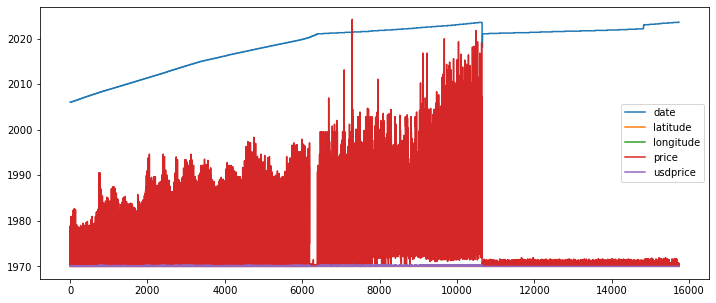

In [36]:
#Plotting Distribution plots
plt
data.distplot(figsize=(12,5))